#### Neuron Initialization
Import modules and setup simulation parameters

In [1]:
from neuron import h
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

from cell_inference.cells.stylizedcell import StylizedCell, CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.ecp import EcpMod, move_position
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointcurrent import PointCurrent

from cell_inference.config import params, paths


h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

#### Set parameters

In [2]:
elec_pos = params.ELECTRODE_POSITION #pos = np.column_stack((x,y,z))
loc_param = [0,0,50,np.pi/4,1,0]  # position (x,y,z,alpha,h,phi)
geo_param = [3,600.,1.25,.28,.28,200.]  # (soma r,trunk l,trunk r,basal r,tuft r,dend l), bounds([3,12],[20,800],[0.6,2.5],[0.1,0.8],[0.1,0.8],[100,300])

In [3]:
def sim_builder(cell_type: CellTypes) -> Simulation:
    if cell_type == CellTypes.ACTIVE:
        biophys = [-1] # (g_pas of soma, basal, apical, gNaTa_t of soma, apical, gSKv3_1 of soma, apical) (3.3e-5, 6.3e-5, 8.8e-5, 2.43, 0.0252, 0.983, 0.0112)
        sim = Simulation(geometry = geo_standard, 
                         electrodes = elec_pos, 
                         cell_type = CellTypes.ACTIVE, 
                         loc_param = loc_param, 
                         geo_param = geo_param, 
                         biophys = biophys, 
                         gmax = .01, 
                         scale = 1.)  # 0.001 -0.012
    else:
        sim = Simulation(geometry = geo_standard,
                         electrodes = params.ELECTRODE_POSITION,
                         cell_type = CellTypes.PASSIVE, 
                         loc_param = loc_param,
                         geo_param = geo_param,
                         soma_injection = soma_injection,
                         ncell = 1) 
        
    return sim

In [4]:
from typing import Union, List, Tuple
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
%matplotlib inline

def plot_along_trunk(sim: Simulation, window: Union[List[float],Tuple[float]], nseg: int, 
                     figsize: Union[List[float],Tuple[float]] = (15,2)) -> Tuple[np.ndarray,np.ndarray,Figure, Axes]:
    cell = sim.cells[0]
    sec_names = [sec.name().split('.')[-1] for sec in cell.all]
    tr_idx = sec_names.index('trunk')
    tr_seg_idx0 = cell.sec_id_in_seg[tr_idx]
    tr_sec = cell.all[tr_idx]
    tr_nseg = tr_sec.nseg
    print('%d segments in the trunk.' % (tr_nseg))
    tr_seg_idx = np.arange(tr_seg_idx0,tr_seg_idx0+tr_nseg)
    tr_segs = cell.get_seg_by_id(tr_seg_idx)
    dend_v = Recorder(tr_segs)
    soma_v = cell.v()

    sim.run_neuron_sim()
    lfp = sim.get_lfp().T
    t = sim.t()

    v_dend = dend_v.as_numpy()
    seg_v = np.vstack((soma_v,v_dend))
    axial_r = np.array([[seg.ri()] for seg in tr_segs])
    axial_current = np.diff(seg_v,n=1,axis=0)/axial_r
    net_axial_current = np.diff(axial_current,n=1,axis=0)
    im = sim.lfp[0].calc_im()[np.hstack((0,tr_seg_idx)),:]
    seg_names = [seg.sec.name().split('.')[-1] + '(%g)' % (seg.x) for seg in [cell.soma(0.5)]+tr_segs]
    
    e_pas = tr_sec.e_pas
    g_pas = tr_sec.g_pas
    area = np.array([[seg.area()] for seg in tr_segs])
    il = g_pas*area*(seg_v[1:,:]-e_pas)*1e-2 # S/cm2*um2*mV = 1e-2 nA
    
    window = [0,12]
    t_idx = (t>=window[0]) & (t<=window[1])  # time index

    nseg = min(nseg,tr_nseg-1)
    iseg = np.hstack((0,np.round(np.linspace(1,tr_nseg-1,nseg)).astype(int)))
    fig, axs = plt.subplots(nrows=nseg+1, ncols=3)
    fig.set_size_inches(figsize[0],figsize[1]*(nseg+1))
    for i,idx in enumerate(iseg):
        axs[i,0].plot(t[t_idx],seg_v[idx,t_idx])
        axs[i,0].set_ylabel(seg_names[idx])
        axs[i,2].plot(t[t_idx],im[idx,t_idx],color='r',label='Transmembrane')
        if idx>0:
            axs[i,1].plot(t[t_idx],-axial_current[idx-1,t_idx],color='orange')
            axs[i,2].plot(t[t_idx],net_axial_current[idx-1,t_idx],linestyle='dotted',color='c',label='net axial')
            axs[i,2].plot(t[t_idx],il[idx-1,t_idx],color='green',label='leak')
    for i in range(3):
        axs[-1,i].set_xlabel('Time (ms)')
    axs[0,0].set_title('membrane voltage (mV)')
    axs[0,1].set_title('soma->trunk directional axial current (nA)')
    axs[0,2].set_title('net axial current(=transmembrane nA)')
    axs[-1,2].legend(loc=1)
    plt.show()
    return lfp, t, fig, axs

#### Active model
Record membrane voltage along the trunk to check the propagation.

20 segments in the trunk.


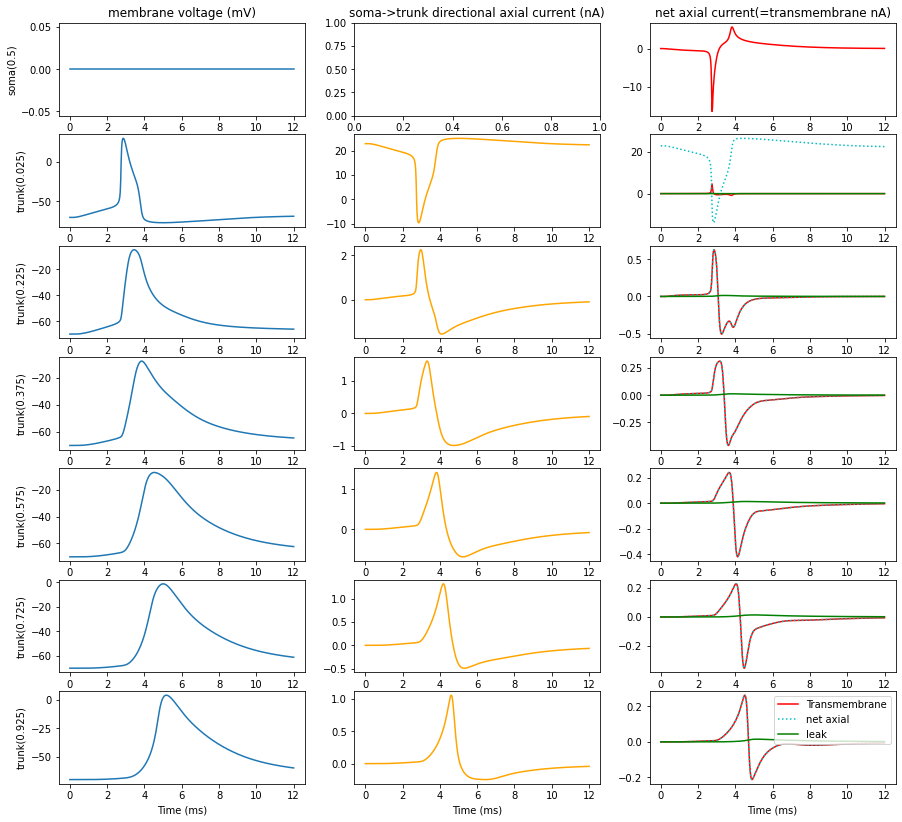

In [5]:
active_sim = sim_builder(CellTypes.ACTIVE)

window = [0,12]
active_lfp, active_t, fig, axs = plot_along_trunk(sim=active_sim,window=window,nseg=6,figsize=(15,2))

#### Passive model
Scale the soma injection to obtain same action potential amplitude in active cell.

In [6]:
groundtruth_lfp = active_lfp
maxIndx = np.argmax(np.absolute(groundtruth_lfp).max(axis=0))  # find maximum absolute value from averaged traces
maxTrace = -groundtruth_lfp[:,maxIndx]
soma_injection = np.insert(maxTrace,0,0.)
# soma_injection = np.insert(-active_sim.lfp[0].calc_im()[0,:],0,0.)

# soma_injection = np.zeros(maxTrace.shape[0])
# soma_injection[10]=1 # using impulse input
# # tidx = (active_t>=2.3) & (active_t<=4.3) # using truncated input
# # soma_injection[tidx] = maxTrace[tidx]
# soma_injection = np.insert(soma_injection,0,0.)

# print(soma_injection.shape)

passive_sim = sim_builder(CellTypes.PASSIVE)
passive_sim.run_neuron_sim()
# active_cell = active_sim.cells[0]
# passive_cell = passive_sim.cells[0]
# scale = (active_cell.v().max()-active_cell._vrest)/(passive_cell.v().max()-passive_cell._vrest)
scale = np.absolute(groundtruth_lfp).max()/np.absolute(passive_sim.get_lfp()).max()
soma_injection = soma_injection*scale

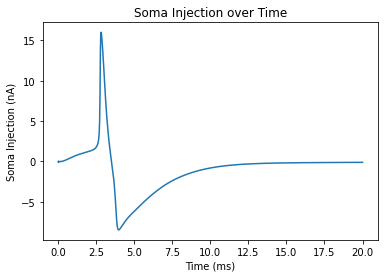

In [7]:
plt.plot(active_t,soma_injection[:-1])
plt.title("Soma Injection over Time")
plt.ylabel("Soma Injection (nA)")
plt.xlabel("Time (ms)")
plt.show()

Record membrane voltage along the trunk to check the propagation.

20 segments in the trunk.


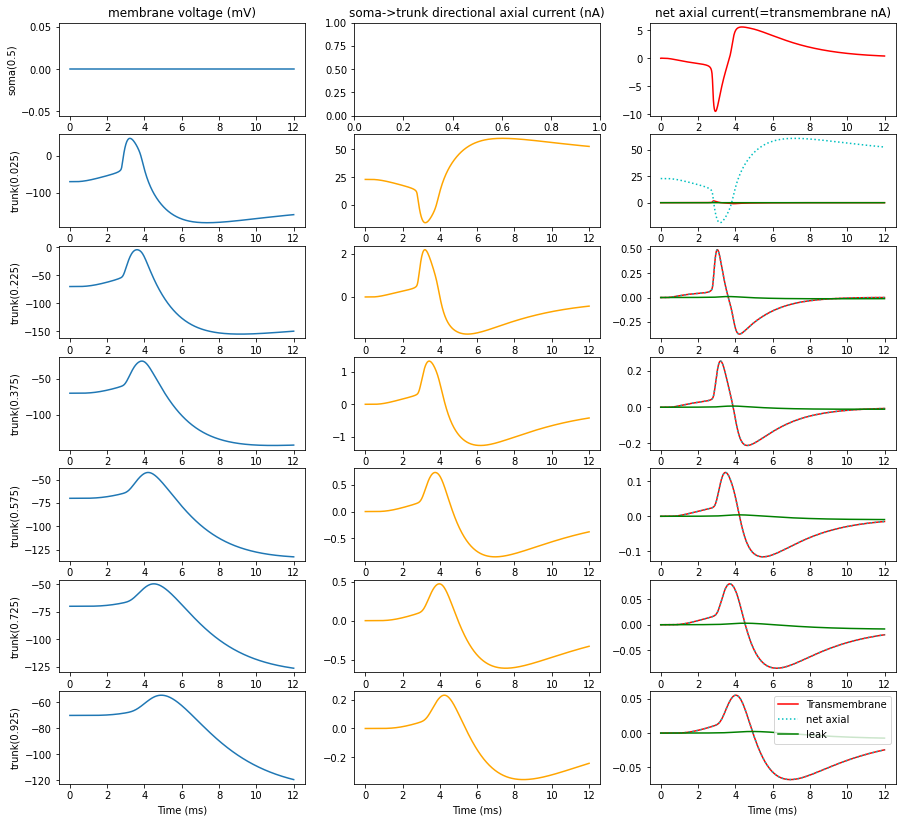

In [8]:
passive_sim = sim_builder(CellTypes.PASSIVE)

window = [0,12]
passive_lfp, passive_t, fig, axs = plot_along_trunk(sim=passive_sim,window=window,nseg=6,figsize=(15,2))

#### Check LFP
Use functions in "utils" module to plot

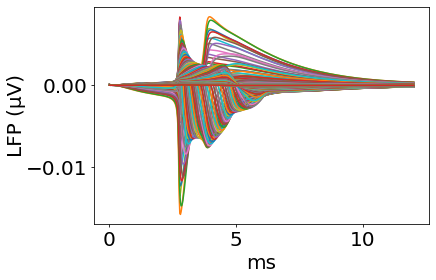

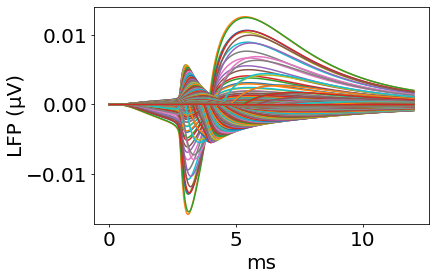

In [9]:
from cell_inference.utils.plotting.plot_results import plot_lfp_traces,plot_lfp_heatmap
%matplotlib inline

# window = [5.,15.01]

active_idx = (active_t>=window[0]) & (active_t<=window[1])  # time index
fig,ax = plot_lfp_traces(active_t[active_idx],active_lfp[active_idx,:],
                         fontsize=20,labelpad=0,tick_length=3,nbins=5)

passive_idx = (passive_t>=window[0]) & (passive_t<=window[1])  # time index
fig,ax = plot_lfp_traces(passive_t[passive_idx],passive_lfp[passive_idx,:],
                         fontsize=20,labelpad=0,tick_length=3,nbins=5)

Using column at x = -8 um


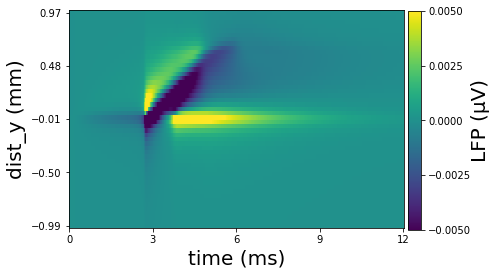

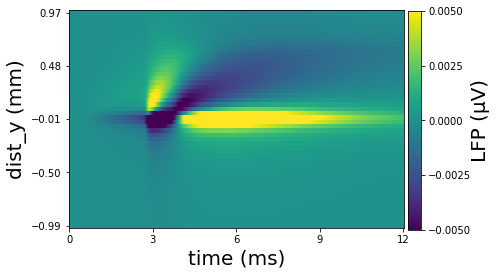

In [10]:
# vlim = 'auto'
vlim = [-0.005,0.005]
ylim = [-1000,1000]

x_dist = np.unique(elec_pos[:,0])
ix = 1
e_idx = (elec_pos[:,0]==x_dist[ix]) & (elec_pos[:,1]>=ylim[0]) & (elec_pos[:,1]<=ylim[1])
print('Using column at x = %g um' % (x_dist[ix]))

fig,ax = plot_lfp_heatmap(active_t[active_idx],params.ELECTRODE_POSITION[e_idx, 1],
                          active_lfp[active_idx][:, e_idx],vlim=vlim,
                          fontsize=20,labelpad=0,ticksize=10,nbins=5)

fig,ax = plot_lfp_heatmap(passive_t[passive_idx],params.ELECTRODE_POSITION[e_idx, 1],
                          passive_lfp[passive_idx][:, e_idx],vlim=vlim,
                          fontsize=20,labelpad=0,ticksize=10,nbins=5)

# set narrower "vlim" can help see more subtle difference in voltage

In [11]:
help(plot_lfp_heatmap) # check docstring

Help on function plot_lfp_heatmap in module cell_inference.utils.plotting.plot_results:

plot_lfp_heatmap(t: numpy.ndarray, elec_d: numpy.ndarray, lfp: numpy.ndarray, savefig: Union[str, NoneType] = None, vlim: str = 'auto', fontsize: int = 40, ticksize: int = 30, labelpad: int = -12, nbins: int = 3, cbbox: Union[List[float], NoneType] = None, cmap: str = 'viridis') -> Tuple[matplotlib.figure.Figure, matplotlib.axes._axes.Axes]
    Plot LFP heatmap.
    
    t: time points (ms). 1D array
    elec_d: electrode distance (um). 1D array
    lfp: LFP traces (uV). If is 2D array, each column is a channel.
    savefig: if specified as string, save figure with the string as file name.
    vlim: value limit for color map, using +/- 3-sigma of lfp for bounds as default. Use 'max' for maximum bound range.
    fontsize: size of font for display
    labelpad: Spacing in points from the Axes bounding box including ticks and tick labels.
    tick_length: length between ticks
    nbins: number of bins

Location Parameters: [0, 0, 50, 0.7853981633974483, 1, 0]
Geometric Parameters: [12, 600.0, 1.25, 0.28, 0.28, 200.0]


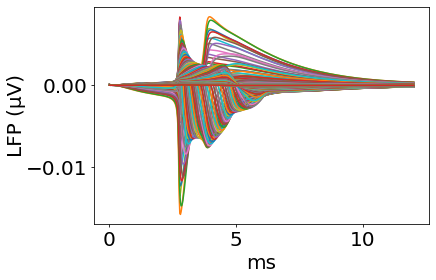

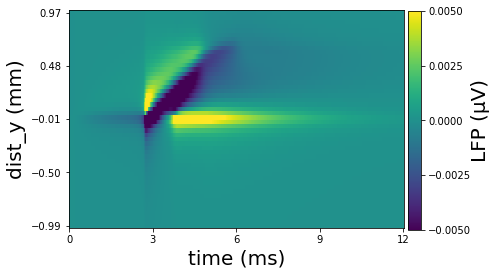

In [12]:
print("Location Parameters: {}".format(loc_param))
print("Geometric Parameters: {}".format(geo_param))

active_idx = (active_t>=window[0]) & (active_t<=window[1])  # time index
fig,ax = plot_lfp_traces(active_t[active_idx],active_lfp[active_idx,:],
                         fontsize=20,labelpad=0,tick_length=3,nbins=5)

fig,ax = plot_lfp_heatmap(active_t[active_idx],params.ELECTRODE_POSITION[e_idx, 1],
                          active_lfp[active_idx][:, e_idx],vlim=vlim,
                          fontsize=20,labelpad=0,ticksize=10,nbins=5)